In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [3]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [4]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [5]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [6]:
import time
CALLS = []
merged = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
merged.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [9]:
target = merged.logP.values
def get_score(id):
    return target[id]

In [301]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
class ChemicalSpace:
    def __init__(self, file, nrows=None):
        if file.split('.')[-1] == 'csv':
            if nrows is not None:
                compounds = pd.read_csv(file, nrows=nrows)
            else:
                compounds = pd.read_csv(file)
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        self.compounds['mol'] = self.compounds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
        self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        self.mol2vec = [DfVec(x) for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')]
        self.mol2vec = np.array([x.vec for x in self.mol2vec])
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
        self.iter_neighbors = []
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def reset_neighbors(self):
        self.iter_neighbors = []
    def add_step_neighbors(self, neighbors):
        self.iter_neighbors.append(neighbors)
    def f(self, X):
        X_numpy = X.detach().numpy()
        # get neighbors
        neighbors = self.get_neighbors(X_numpy)[0]
        # add neighbors to list of neighbors
        self.add_step_neighbors(neighbors)
        # get scores of neighbors
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float64, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float64, requires_grad=True)
        distance = torch.sum((X - coords)**2, dim=1)
        distance_weights = (1 / (distance+ 1e-15)) / torch.sum(1 / (distance + 1e-15))
        weighted_score = torch.sum(scores * distance_weights)
        return weighted_score

In [302]:
space = ChemicalSpace('250k_rndm_zinc_drugs_clean_3.csv', nrows=100000)

In [303]:
space.mol2vec[0]

array([ 1.24336228e-01, -1.36083496e+00, -2.71603155e+00,  5.38911390e+00,
        4.20234203e-01, -8.66732299e-01, -1.12547970e+01, -1.12598085e+00,
        1.01145592e+01,  3.66473341e+00, -4.31562614e+00, -1.37760258e+00,
       -7.61641407e+00,  8.66655350e-01, -5.47446680e+00, -1.20254374e+00,
        5.33635998e+00, -2.71455169e+00, -2.62653685e+00,  4.66232538e+00,
       -3.13242048e-01,  6.73635483e+00,  1.31712027e+01,  6.55209923e+00,
       -8.21217823e+00, -1.06210411e+00,  3.55781198e-01, -9.52867699e+00,
       -1.59662008e+00,  1.59179604e+00,  9.98129749e+00, -6.53942347e+00,
       -5.31754398e+00, -5.60516977e+00,  2.46172619e+00,  7.53844142e-01,
        1.09183776e+00, -1.36837259e-01,  8.86807632e+00,  4.71449471e+00,
       -3.02693391e+00,  7.95578539e-01, -3.61779046e+00,  8.00926685e-01,
       -9.93466759e+00,  3.83945441e+00,  4.74679053e-01,  7.50044489e+00,
       -6.76615953e+00,  7.35974550e+00,  6.19621086e+00, -4.97002125e+00,
       -4.49713326e+00, -

In [304]:
space.init_knn(n_neighbors=15)

In [307]:
space.get_neighbors(space.mol2vec[7])

array([[    7, 53831, 43213, 66951, 47819, 68923, 11544, 82184, 92123,
        20743, 99364, 37048, 80168, 91999, 24709]])

In [308]:
space.get_neighbors(space.mol2vec[844])

array([[ 6755,   844, 37259,  7825, 10304, 30579, 81280, 21518, 97456,
        85016, 87258, 47374, 31096, 29454, 66776]])

In [309]:
space.set_objective(get_score)

In [310]:
space.get_objective(84)

2.37584

In [311]:
def create_distribs(mol2vec):
    means = np.ones(mol2vec.shape[1])
    stds = np.ones(mol2vec.shape[1])
    for i in range(mol2vec.shape[1]):
        means[i] = np.mean(mol2vec[:, i])
        stds[i] = np.std(mol2vec[:, i])
    return means, stds

In [312]:
def sample_from_distribs(means, stds):
    return np.random.normal(means, stds)

In [313]:
means, stds = create_distribs(space.mol2vec)

In [314]:
debug_vector = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float64, requires_grad=True)

In [315]:
space.f(debug_vector)

tensor(3.7427, dtype=torch.float64, grad_fn=<SumBackward0>)

In [316]:
from utils import *
global_seed(654)

Global seed set to 654


In [317]:
# optimize f(x)
X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float64, requires_grad=True)

In [318]:
from torch.optim import Adam
optimizer = Adam([X], lr=0.1)

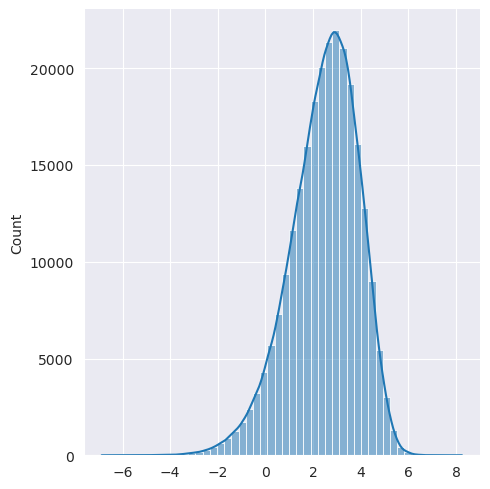

In [319]:
import seaborn as sns
_=sns.displot(target, bins=50, kde=True)

In [321]:
CALLS = []
best = 0
for i in range(2000):
    optimizer.zero_grad()
    loss =- space.f(X)
    loss.backward()
    optimizer.step()
    if loss.item() < best:
        best = loss.item()
    if i % 100 == 0:
        print(f'Iteration: {i}', f'Loss: {loss.item()}')

Iteration: 0 Loss: -5.2639100223830555
Iteration: 100 Loss: -5.912651584830228
Iteration: 200 Loss: -5.9127185215988
Iteration: 300 Loss: -5.912719289824208
Iteration: 400 Loss: -5.912714150423738
Iteration: 500 Loss: -5.9126939018114415
Iteration: 600 Loss: -5.912719305983008
Iteration: 700 Loss: -5.912704733793409
Iteration: 800 Loss: -5.9126719240357515
Iteration: 900 Loss: -5.912705242267429
Iteration: 1000 Loss: -5.912702826148942
Iteration: 1100 Loss: -5.9126935929923725
Iteration: 1200 Loss: -5.912664413922823
Iteration: 1300 Loss: -5.912687852645535
Iteration: 1400 Loss: -5.912680407426772
Iteration: 1500 Loss: -5.912674552447998
Iteration: 1600 Loss: -5.912685055771907
Iteration: 1700 Loss: -5.912665026401897
Iteration: 1800 Loss: -5.912679187844406
Iteration: 1900 Loss: -5.91264135922827


In [322]:
from scipy.stats import percentileofscore
# flatten list of lists
def unique_comps(iter_neighbors):
    return len(set([item for sublist in iter_neighbors for item in sublist]))
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {-best}')
print(f'Percentile: {percentileofscore(target, -best)}')

Visited 111 unique compounds
Best score: 5.9127198466803526
Percentile: 99.92944619270008


In [323]:
lrs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [324]:
for lr in lrs:
    space.reset_neighbors()
    print(f'Learning rate: {lr}')
    global_seed(676550)
    X = torch.tensor(sample_from_distribs(means, stds), dtype=torch.float64, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in range(2000):
        optimizer.zero_grad()
        loss = space.f(X)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iteration {i}: {loss.item()}')
            lrs_timeline[lr].append(loss.item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(unique_comps(space.iter_neighbors))

Learning rate: 0.0001
Global seed set to 676550
Iteration 0: 3.003916017916602
Iteration 100: 2.838318661032901
Iteration 200: 2.8371774486220467
Iteration 300: 2.836041853515394
Iteration 400: 2.848587364107208
Iteration 500: 2.8475680013401288
Iteration 600: 2.6476604023013737
Iteration 700: 2.561672661623218
Iteration 800: 2.5609835480940943
Iteration 900: 2.3820859095313045
Iteration 1000: 2.380929878287091
Iteration 1100: 2.350895054943141
Iteration 1200: 2.3497383380973504
Iteration 1300: 2.3241373792463733
Iteration 1400: 2.323190776902228
Iteration 1500: 2.1207793384203097
Iteration 1600: 2.055071723230593
Iteration 1700: 2.054196638384277
Iteration 1800: 2.0533535114093677
Iteration 1900: 2.0525297156124718
Visited 0 points
Learning rate: 0.001
Global seed set to 676550
Iteration 0: 3.003916017916602
Iteration 100: 2.3814719278322234
Iteration 200: 2.052376134129872
Iteration 300: 1.7366097524378994
Iteration 400: 1.6457533272023608
Iteration 500: 1.4712149378307562
Iteration 

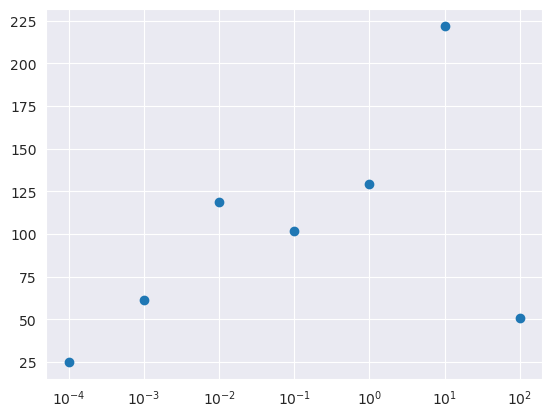

In [325]:
# plot learning rate vs exploration index plot in log scale
_ = plt.plot(lrs, exploration_index, 'o')
plt.xscale('log')

In [326]:
for lr in lrs:
    print(f'Best score for lr={lr}: {np.min(lrs_timeline[lr]):.3f}')

Best score for lr=0.0001: 2.053
Best score for lr=0.001: 0.746
Best score for lr=0.01: -3.033
Best score for lr=0.1: -4.896
Best score for lr=1: -6.032
Best score for lr=10: -2.553
Best score for lr=100: -2.241


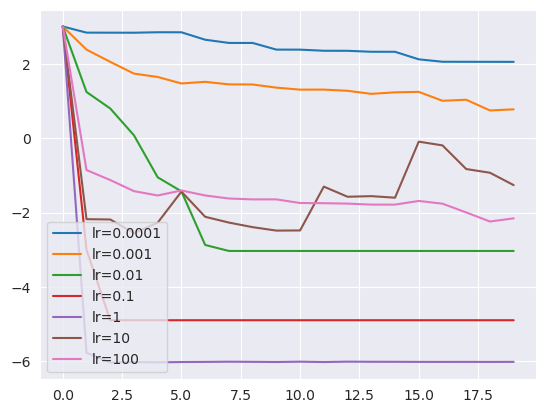

In [327]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [328]:
from scipy import stats

In [329]:
#percentile of each best logP
for lr, exp in zip(lrs, exploration_index):
    print(f'Percentile of best score for lr={lr}: {stats.percentileofscore(target, np.min(lrs_timeline[lr]))} with {exp} samples')

Percentile of best score for lr=0.0001: 35.432041851235695 with 25 samples
Percentile of best score for lr=0.001: 12.132849612154496 with 61 samples
Percentile of best score for lr=0.01: 0.1022228458038524 with 119 samples
Percentile of best score for lr=0.1: 0.005211360766470907 with 102 samples
Percentile of best score for lr=1: 0.0012026217153394399 with 129 samples
Percentile of best score for lr=10: 0.2148684131406466 with 222 samples
Percentile of best score for lr=100: 0.3395401976308352 with 51 samples


In [330]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(space.mol2vec)

PCA(n_components=2)

ValueError: 'c' argument has 249455 elements, which is inconsistent with 'x' and 'y' with size 100000.

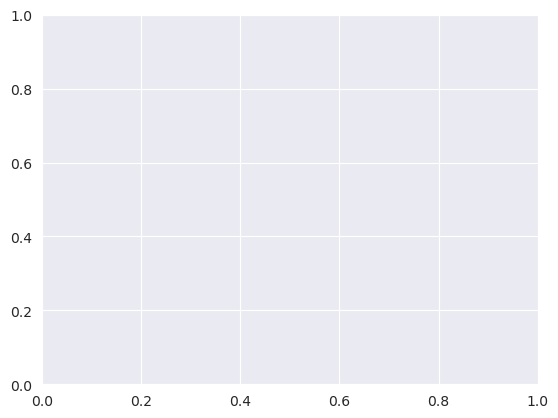

In [331]:
# plot PCA of mol2vec, use target as color
_ = plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target, cmap='viridis')
plt.colorbar()

In [332]:
# test evrything with lr 10
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True)
optimizer = Adam([X], lr=0.1)
CALLS = []
history = np.zeros(10000)

Global seed set to 676550


In [333]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(10000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 500 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: 3.003916017916602, neighbors: [[ 6063 55605 87428 57906 19635 13970 39899 85909 55532 46315 26611 81127
  80010 42222 53538]]
Iteration 500: -4.895687703626569, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 45363]]
Iteration 1000: -4.895667135306331, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 45363]]
Iteration 1500: -4.895654935571709, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 47410]]
Iteration 2000: -4.895558262484745, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 47410]]
Iteration 2500: -4.895519257420825, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 47410]]
Iteration 3000: -4.89566222063598, neighbors: [[83930 20563 76174 49841 90358 80269 28616  3289 23489 39004 12697 67087
   8332  2529 47410]]
Itera

In [334]:
space.get_neighbors(X.detach().numpy())
for i in space.get_neighbors(X.detach().numpy())[0]:
    print(space.get_objective(i))

-4.8957
-2.5778
-1.6296
-1.8385
-1.8385
-0.0675
-0.9784
-1.5634
-2.6265
-1.45
-1.8401
-2.0031
-0.8141
-1.5618
-3.7299


In [335]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 102 unique compounds
Best score: -4.895699989237071
Percentile: 0.005211360766470907
Best f(X): -4.89569988670765


In [336]:
# best neighbor percentile
percentileofscore(target, space.get_objective(space.get_neighbors(best_X.detach().numpy())[0][0]))

0.005211360766470907

In [337]:
space.f(best_X)

tensor(-4.8957, dtype=torch.float64, grad_fn=<SumBackward0>)

In [338]:
np.sum(target < best)

13

In [339]:
np.sum(target < space.get_objective(space.get_neighbors(best_X.detach().numpy())[0][0]))

12

In [340]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-4.8957
-2.5778
-1.6296
-1.8385
-1.8385
-0.0675
-0.9784
-1.5634
-2.6265
-1.45
-1.8401
-2.0031
-0.8141
-1.5618
-3.7299


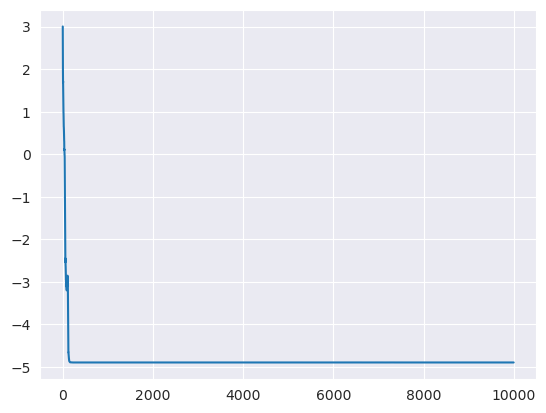

In [341]:
_ = plt.plot(history)

In [343]:
best_X

tensor([ 8.8826e-01, -1.0986e+00, -3.9666e+00, -2.3695e+00,  2.2988e+00,
        -1.9275e+00, -7.4292e+00,  2.5414e-01,  1.0522e+00,  5.9728e-01,
         1.3451e+00,  2.4832e+00, -2.5078e+00,  2.8775e+00, -6.4052e+00,
         2.8906e+00,  5.7562e+00, -8.2643e+00, -7.3822e+00,  6.2291e+00,
         1.2432e+00,  2.4418e+00,  1.3741e+01,  6.5652e+00, -3.2890e+00,
         2.7559e+00, -3.6333e+00, -3.6377e+00,  3.3594e-01, -1.6966e+00,
         1.6621e+00, -2.5222e+00, -3.5123e+00, -6.1789e-01, -1.2889e-02,
         1.2452e+00, -1.5687e+00,  1.0157e+00,  4.3736e+00,  3.0741e+00,
         1.2855e+00,  2.3231e+00, -7.9825e-01,  5.0459e-03, -4.3931e+00,
         3.2863e+00,  4.2885e+00,  6.1907e+00, -3.3568e+00,  1.6526e+00,
         2.1929e-01, -1.4488e+00, -1.9195e-01, -3.5436e+00, -9.4485e+00,
        -8.7956e+00, -1.3834e+00,  2.8192e+00,  7.4776e-01,  5.2620e+00,
        -2.6454e+00, -2.6820e+00, -3.5610e+00,  4.0217e+00, -1.3552e+01,
        -8.1890e-01,  3.3056e+00,  1.8779e+00, -6.5

In [344]:
space.f(best_X)

tensor(-4.8957, dtype=torch.float64, grad_fn=<SumBackward0>)

In [345]:
space.get_neighbors(best_X)

array([[83930, 20563, 76174, 49841, 90358, 80269, 28616,  3289, 23489,
        39004, 12697, 67087,  8332,  2529, 47410]])

In [346]:
for i in space.get_neighbors(best_X)[0]:
    print(space.get_objective(i))

-4.8957
-2.5778
-1.6296
-1.8385
-1.8385
-0.0675
-0.9784
-1.5634
-2.6265
-1.45
-1.8401
-2.0031
-0.8141
-1.5618
-3.7299


In [347]:
space.mol2vec.shape

(100000, 300)

In [64]:
global_seed(676550)
X = torch.tensor(sample_from_distribs(means, stds), requires_grad=True, dtype=torch.float64)
optimizer = Adam([X], lr=1)
CALLS = []
history = np.zeros(2000)
X_positions = np.zeros((2000, 300))
x_scores = np.zeros(2000)

Global seed set to 676550


In [65]:
best = 0
best_X = None
space.reset_neighbors()
for i in range(2000):
    optimizer.zero_grad()
    loss = space.f(X)
    loss.backward()
    optimizer.step()
    history[i] = loss.item()
    X_positions[i] = X.detach().numpy()
    x_scores[i] = loss.item()
    if loss.item() < best:
        best = loss.item()
        best_f = space.f(X)
        best_X = X.clone().detach()
    if i % 100 == 0:
        print(f'Iteration {i}: {loss.item()}, neighbors: {space.get_neighbors(X.detach().numpy())}')

Iteration 0: 2.7327631168779676, neighbors: [[55605 87428  6063 33351 39899 53538 19635 47790 84541 73198]]
Iteration 100: -3.8364540731193544, neighbors: [[86172 99662 40860   940 36986 44889 65924 89266 73087 21779]]
Iteration 200: -4.976183672887945, neighbors: [[86172 99662   940 40860 36986 44889 65924 21779 73087 89266]]
Iteration 300: -4.825182930192521, neighbors: [[86172 99662   940 40860 36986 44889 65924 89266 73087 21779]]
Iteration 400: -4.961169805015045, neighbors: [[86172 99662   940 40860 36986 65924 44889 89266 73087 21779]]
Iteration 500: -4.93717568134138, neighbors: [[86172 99662   940 40860 36986 44889 65924 89266 21779 73087]]
Iteration 600: -4.773256984536437, neighbors: [[86172 99662 40860   940 36986 44889 65924 89266 21779 73087]]
Iteration 700: -4.78759063500939, neighbors: [[86172 99662   940 40860 36986 44889 65924 89266 21779 73087]]
Iteration 800: -4.746340238642192, neighbors: [[86172 99662 40860   940 36986 44889 65924 89266 21779 73087]]
Iteration 900

In [66]:
print(f'Visited {unique_comps(space.iter_neighbors)} unique compounds')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')
print(f'Best f(X): {best_f}')

Visited 97 unique compounds
Best score: -5.370998984526356
Percentile: 0.002004369525565733
Best f(X): -4.477017162920529


In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
all_points = np.concatenate((space.mol2vec, X_positions), axis=0)
all_tsne = tsne.fit_transform(all_points)

In [68]:
# separate mol2vec and X_positions
mol2vec_tsne = all_tsne[:space.mol2vec.shape[0]]
X_positions_tsne = all_tsne[space.mol2vec.shape[0]:]

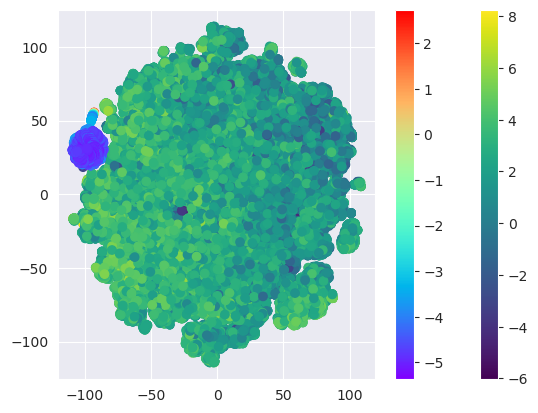

In [70]:
# plot TSNE of mol2vec, use target as color
_ = plt.scatter(mol2vec_tsne[:, 0], mol2vec_tsne[:, 1], c=target[:100000], cmap='viridis')
_ = plt.colorbar()
_ = plt.scatter(X_positions_tsne[:, 0], X_positions_tsne[:, 1], c=x_scores, cmap='rainbow')
# add two colorbar with name
plt.colorbar()

In [71]:
X_positions_pca = pca.transform(X_positions)

In [72]:
!mkdir images_logp

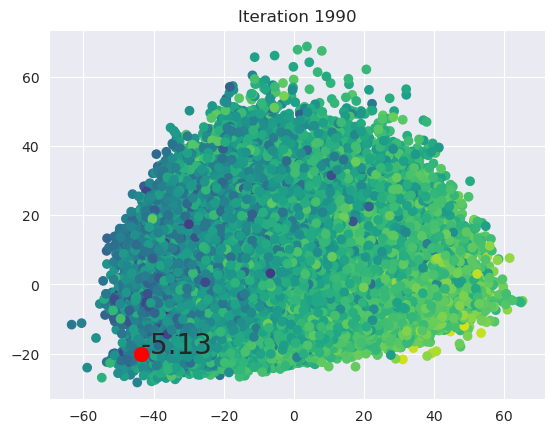

In [80]:
import imageio
images = []
for i in range(0, 2000, 10):
    plt.clf()
    plt.scatter(pca.transform(space.mol2vec)[:, 0], pca.transform(space.mol2vec)[:, 1], c=target[:100000], cmap='viridis')
    plt.scatter(X_positions_pca[i, 0], X_positions_pca[i, 1], c='red', s=100)
    plt.text(X_positions_pca[i, 0], X_positions_pca[i, 1], f'{x_scores[i]:.2f}', fontsize=20)
    plt.title(f'Iteration {i}')
    plt.savefig(f'images_logp/{i}.png')
    images.append(imageio.v2.imread(f'images_logp/{i}.png'))

In [81]:
# save as video
imageio.mimsave('movie_zinc_logp.mp4', images)